

# Text Clustering

> Take five different samples of Gutenberg digital books, which are all of five different genres and of five different authors, that are semantically similar. Separate and set aside unbiased random partitions for training and test (Do you really need test section in clustering?).


> The overall aim is to produce similar clusters and compare them; analyze the pros and cons of algorithms, generate and communicate the insights.


**Prepare the data:** create random samples of 200 documents of each book, representative of the source input.

**Preprocess the data;** prepare the records of 150 words records for each document, 

**Label** them as a, b, c etc. as per the book they belong to so can later compare with clusters.

**Transform** to BOW and TF-IDF (also use other features LDA, Word-Embedding).

Use at least K-means, EM, Hierarchical clustering **algorithms** to compare.

**Evaluation**: Calculate Kappa against true authors,Consistency, Coherence and Silhouette.

**Perform Error-Analysis:** Identity what were the characteristics of the instance records that threw the machine off, using the top 10 frequent words and/or top collocations.

**Document** your steps, explain the results effectively, using graphs.

**Verify and validate** your programs; Make sure your programs run without syntax or logical errors.

 

## **Rubric**: (accounts for 20% of the final grade.)

1. Choose data of your choice, (labelled data) 1%

2. Preprocessing and Data Cleansing 1%

3. Feature Engineering 2%

4. Use K-means, EM, Hierarchical clustering algorithms 3%

5. Perform Evaluations, 2%

6. Compare and decide which clustering result is the closest to the human labels 2%

7. Perform Error Analysis, 3%

8. Perform Visualizations, Graph the results  1%

9. presentation 2%

10. Report, detail explanations 3%



In [231]:
import nltk
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics # confusion matrix

from urllib.request import urlopen
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import v_measure_score

In [232]:
nltk.download('stopwords') 
nltk.download('gutenberg')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

https://www.gutenberg.org/ebooks/1534  <br>
Antony and Cleopatra by William Shakespeare<br>
GENERES:Plays-->Theatre-Drama -Romance <br>
https://www.gutenberg.org/files/1534/1534-0.txt

<hr>

https://www.gutenberg.org/ebooks/28282 <br>
Egyptian Literature by Epiphanius Wilson <br>
GENERES: Fantasy > Mythology<br>
https://www.gutenberg.org/files/28282/28282-0.txt

<hr>


https://www.gutenberg.org/ebooks/9799 <br>
It Happened in Egypt by A. M. Williamson and C. N. Williamson<br>
GENRES: Travel-Classic<br>
https://www.gutenberg.org/cache/epub/30624/pg30624.txt

<hr>


https://www.gutenberg.org/ebooks/43662 <br>
Myths and Legends of Ancient Egypt by Lewis Spence <br>
GENERES: Religion -Folklore <br>
https://www.gutenberg.org/files/43662/43662-0.txt

<hr>


https://www.gutenberg.org/ebooks/64849 <br>
The dawn of astronomy by Sir Norman Lockyer<br>
GENERES : astronomy <br>
https://www.gutenberg.org/files/64849/64849-0.txt





In [233]:
class Sampling:
 
  #cleaning book data from stop words and punctuation
  def wordPreparation(tokenized_word, flg_stemm=False, flg_lemm=True):
    stop_words=set(stopwords.words("english"))
    
    ## Removing stop words and punctuation 
    filtered_words=[x.lower() for x in tokenized_word if x.lower() not in stop_words and x.isalnum() and x.lower() not in ['project','gutenberg']]
    
    
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        filtered_words = [ps.stem(word) for word in filtered_words]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        filtered_words = [lem.lemmatize(word) for word in filtered_words]
  
    
    return filtered_words

  def read_url(url):
    txt_file = urlopen(url)
    txt=""
    flag=False
    for line in txt_file:
      decoded_line = line.decode("utf-8")
      if flag:
        txt+= decoded_line
      elif "*** START" in decoded_line or "***START" in decoded_line:
        flag = True
      elif "***END" in decoded_line or "*** END" in decoded_line:
        flag = False
    return txt
 
  #divide book to partitions(150 word) and 200 sample if founded 
  def getSamplesOfBook(filtered_words,book_name):
    samples = []
    n= len(filtered_words)
    count= 0
 
    #shuffle book words 
    #np.random.shuffle(filtered_words)
    
    while n>150 and count <200:
      part = filtered_words[(count*150):150+(count*150)]
      n-= 150
      count+=1
      ## back to string from list
      text = " ".join(part)
      #row = (part,book_name)
      samples.append( (text,part, book_name))
      df = pd.DataFrame(samples,columns=['text','words','book_name'])
    return df

In [234]:
#list of books names
book_list = ['Antony and Cleopatra, by William Shakespeare',
             'Egyptian Literature by Epiphanius Wilson',
             'It Happened in Egypt',
             'Myths and Legends of Ancient Egypt',
             'The dawn of astronomy by Sir Norman Lockyer'] 

#books' text url
books_urls = ['https://www.gutenberg.org/files/1534/1534-0.txt',
             'https://www.gutenberg.org/files/28282/28282-0.txt',
             'https://www.gutenberg.org/cache/epub/9799/pg9799.txt',
             'https://www.gutenberg.org/files/43662/43662-0.txt',
             'https://www.gutenberg.org/files/64849/64849-0.txt']

df = pd.DataFrame(columns=['text','words','book_name','label']) #declare datafram for result

#get all books of gutenberg and sampling them
for i in range(len(book_list)):
  url = books_urls[i]
  txt= Sampling.read_url(url)
  #txt = urlopen(books_urls[i]).read().decode('utf-8')
  tokenized_word = nltk.word_tokenize(txt)
  #tokenized_word = nltk.RegexpTokenizer(r"\w+").tokenize(txt)
  filtered_words = Sampling.wordPreparation(tokenized_word,flg_stemm=True, flg_lemm=False)
  s = Sampling.getSamplesOfBook(filtered_words,book_list[i])
  s['label'] = i+1
  df = df.append(s,ignore_index=True)

In [235]:
df = df.sample(frac=1,random_state=43).reset_index(drop=True)

In [236]:
df

text  ... label
0    orient therefor give us inform toward determin...  ...     5
1    hermopoli magna feet statu god inscrib upon sl...  ...     2
2    fought thalû zaru shaï nubia thalû horu took f...  ...     4
3    base vast monument king cheop vainli sought et...  ...     3
4    jackal hand realist accord might right earth l...  ...     4
..                                                 ...  ...   ...
900  listen thu spake behold thi mother thi elder b...  ...     2
901  typhon wife call taurt thoueri repres gener hi...  ...     5
902  god cometh forth hidden habit food falleth eas...  ...     2
903  gold far away across gleam floor blossom long ...  ...     3
904  see earli observ made horizon obviou light bod...  ...     5

[905 rows x 4 columns]

In [237]:
def mostFreq(df,y):
  lst_tokens = df[df["book_name"]==y]["words"]
  test_list1 = []
  for i in lst_tokens :
    test_list1 = np.append(test_list1, i, axis=None)

  lst_tokens = test_list1
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 4))
  fig.suptitle("Most frequent words in "+y, fontsize=15)
    
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
    
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
  dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.show()

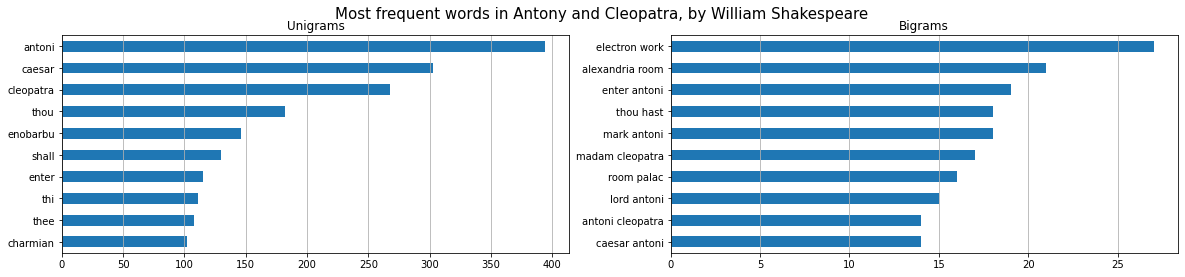

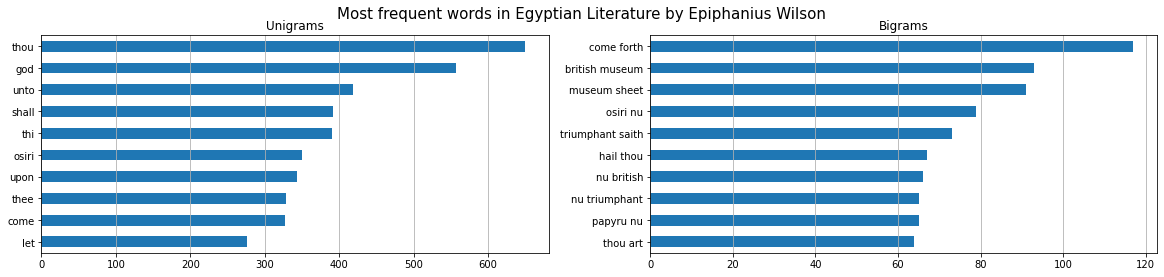

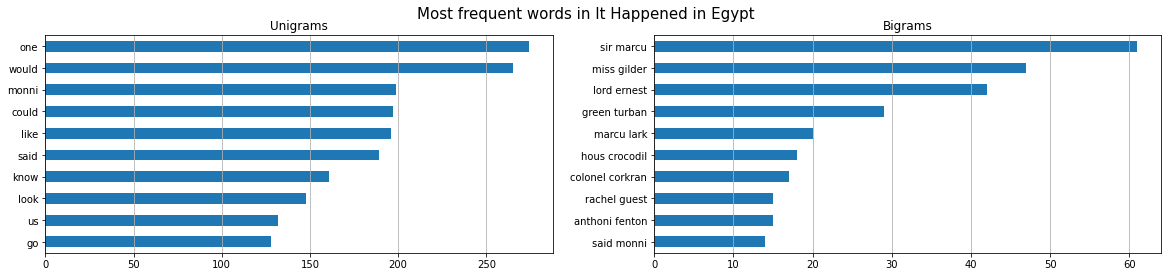

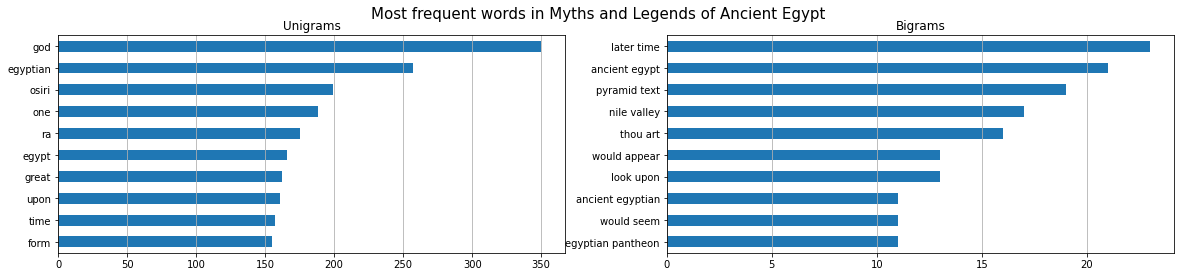

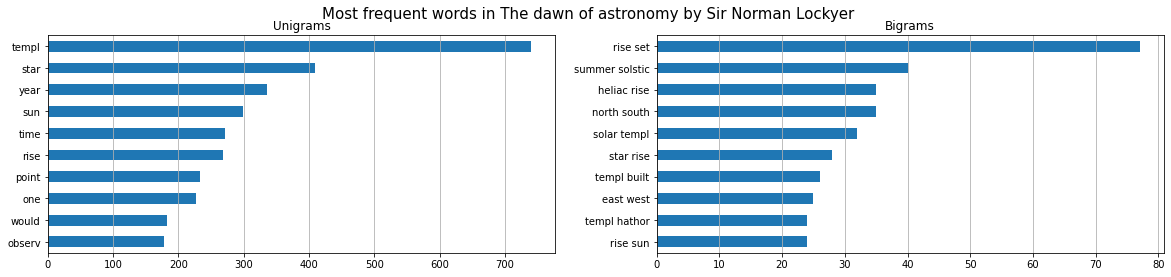

In [238]:
for book in book_list:
  mostFreq(df,book)

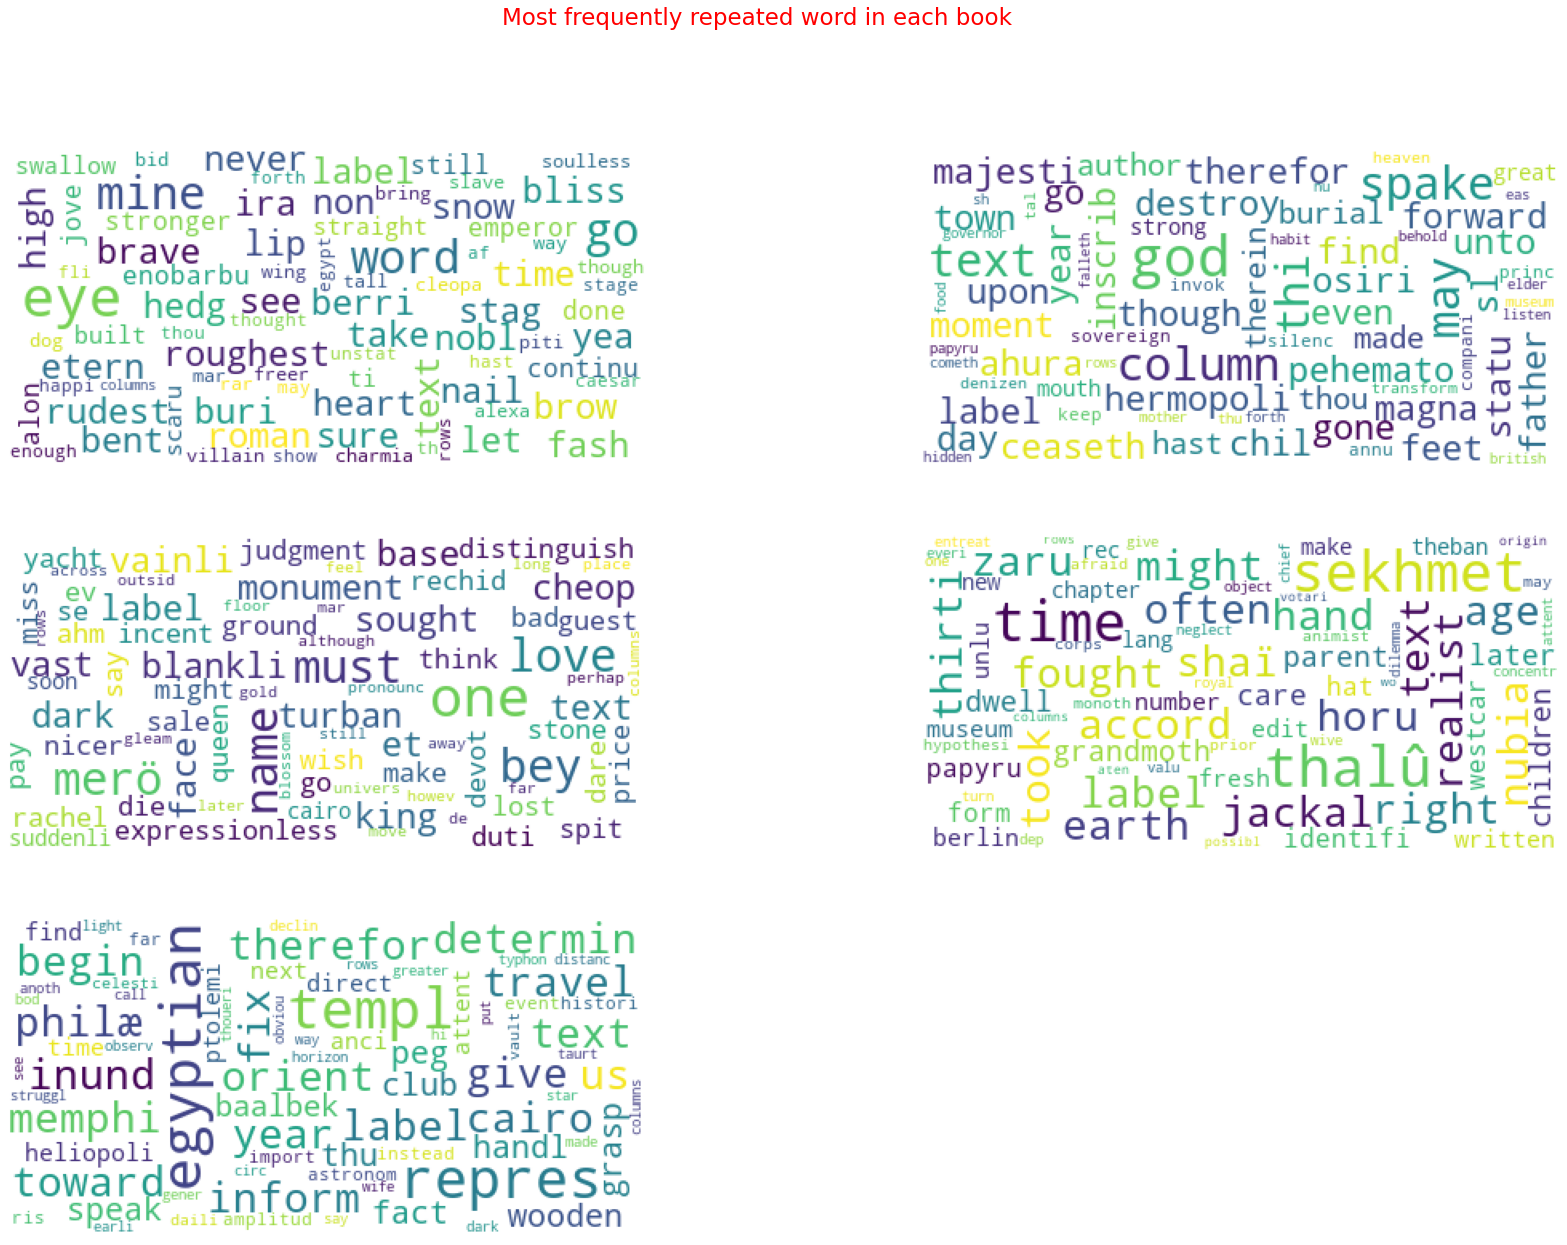

In [239]:
import wordcloud
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
fig.suptitle('Most frequently repeated word in each book',size=23,c='r')

plt.subplot(3,2, 1)
#plt.title("The World War and What was Behind It Or The Story of the Map of Europe by Bénézet")
wc = wordcloud.WordCloud(background_color='white', max_words=100, max_font_size=35)
wc = wc.generate(str(df[df['label']==1]))

fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)


plt.subplot(3,2, 2)
#plt.title("Eighteen Months in the War Zone by Kate John Finze")
wc = wordcloud.WordCloud(background_color='white', max_words=100, max_font_size=35)
wc = wc.generate(str(df[df['label']==2]))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)

plt.subplot(3,2, 3)
#plt.title(" A Short History of the Great War by A. F. Pollard")
wc = wordcloud.WordCloud(background_color='white', max_words=100, max_font_size=35)
wc = wc.generate(str(df[df['label']==3]))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)

plt.subplot(3,2, 4)
#plt.title(" The Story of the Great War")
wc = wordcloud.WordCloud(background_color='white', max_words=100, max_font_size=35)
wc = wc.generate(str(df[df['label']==4]))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)

plt.subplot(3,2, 5)
#plt.title("How I Filmed the War by Geoffrey H. Malins")
wc = wordcloud.WordCloud(background_color='white', max_words=100, max_font_size=35)
wc = wc.generate(str(df[df['label']==5]))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)

plt.show()

In [240]:
#Separate and set aside unbiased ---random--- partitions for training, validation and testing.
df = df.reindex()
X = df.iloc[:,0]
y = df.iloc[:,-1].astype('int32')

In [241]:
#Separate and set aside unbiased ---random--- partitions for training, validation and testing.
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=43)

# Transformations

## BOW

In [242]:
#Bow
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(X)
X_bow = vectorizer.transform(X)

## tfidf

In [243]:
#tfidf
Tfidf = TfidfTransformer()
Tfidf = Tfidf.fit(X_bow)
X_tfidf = Tfidf.transform(X_bow)

In [244]:
X_tfidf.shape

(905, 10333)

## LDA

In [245]:
from gensim import corpora, models, similarities

dictionary = corpora.Dictionary(df.iloc[:,1])
corpus = [dictionary.doc2bow(text) for text in df.iloc[:,1]]
tfidf_2 = models.TfidfModel(corpus)  # step 1 -- initialize a model
corpus_tfidf = tfidf_2[corpus]
lda_model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5, random_state=100)
corpus_lda = lda_model[corpus_tfidf]

In [246]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation( n_components=5,random_state=42,n_jobs=-1).fit(X_bow)
X_lda =LDA.transform(X_bow)

### Coherence

In [247]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model, texts=df.iloc[:,1], dictionary=dictionary ,coherence='c_v')
coherence = cm.get_coherence()  # get coherence value
print(coherence)

0.34487114236719646


In [248]:
!pip install pyLDAvis

In [249]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.4)


In [250]:
# Compute Perplexity
from gensim.models import CoherenceModel
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['words'], dictionary=lda_model.id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.986719824134536

Coherence Score:  0.34487114236719646


In [251]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.017301 -0.001929       1        1  45.121574
0     -0.009400 -0.010513       2        1  23.247911
4      0.000265 -0.003867       3        1  15.574536
1     -0.000950  0.008498       4        1   8.464775
2     -0.007216  0.007810       5        1   7.591204, topic_info=         Term        Freq       Total Category  logprob  loglift
91      templ  183.000000  183.000000  Default  30.0000  30.0000
89       star  117.000000  117.000000  Default  29.0000  29.0000
105      year  100.000000  100.000000  Default  28.0000  28.0000
104     would   99.000000   99.000000  Default  27.0000  27.0000
262      said   89.000000   89.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
149      like    5.617042   85.847406   Topic5  -7.5146  -0.1486
55       make    5.596894   84.157712   Topic5  -7.5182  -0.1323
195      upon    5.742987  104.872410   Topic5  -7.4924  -0.3266
428  egyptian    5.631982   95.633897   Topic5  -7.5119  -0.2539
148       let    5.553351  105.966392   Topic5  -7.5260  -0.3705

[400 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2756      1  0.241052  1798
2756      2  0.562455  1798
2756      3  0.080351  1798
2756      4  0.080351  1798
2756      5  0.080351  1798
...     ...       ...   ...
8861      1  0.320854     δ
8861      2  0.213902     δ
8861      3  0.320854     δ
8861      4  0.106951     δ
8861      5  0.106951     δ

[1425 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

## word embedding 

In [252]:
#!pip install gensim

### Word2Vec

In [253]:
from gensim import models
from gensim.models import Word2Vec
word2vec_model = Word2Vec(df.iloc[:,1], min_count=1)

In [254]:
vector=word2vec_model.wv['egypt']## get numpy vector of a word
#print(vector)

In [255]:
sims = word2vec_model.wv.most_similar('egypt', topn=10)  # get other similar words
print(sims)

[('could', 0.9997578859329224), ('seem', 0.9997119903564453), ('must', 0.9997075796127319), ('question', 0.9994892477989197), ('dynasti', 0.9993976354598999), ('mani', 0.999376654624939), ('less', 0.9993283152580261), ('far', 0.9992483854293823), ('certain', 0.9992421865463257), ('idea', 0.9992327690124512)]


In [256]:
#for plotting word2vec
# https://stackoverflow.com/questions/31077145/trying-to-use-tsne-from-sklearn-for-visualizing-my-high-dimensional-data-but-g
from sklearn.manifold import TSNE
vocab = list(word2vec_model.wv.vocab)

words_ak = []
embeddings_ak = []
for word in list(vocab):
    embeddings_ak.append(word2vec_model.wv[word])
    words_ak.append(word)

tsne = TSNE(n_components=2,random_state=100,n_jobs=-1)
X_tsne = tsne.fit_transform(embeddings_ak)


df_word2vec = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df_word2vec

#Xtfidf_train.todense()

x          y
orient       -17.502615  72.117393
therefor     -15.874029  67.683838
give         -28.002726  67.127586
us           -28.176085  71.767067
inform        -8.309536  64.056366
...                 ...        ...
sandalwood    10.770530  -0.138301
amenemhāt    -40.824352 -37.165623
ἁρπεδονάπται -16.636909  26.211674
democritu     -7.843561  12.868226
1380         -36.846909  33.660683

[10362 rows x 2 columns]

In [257]:
import matplotlib.cm as cm

def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

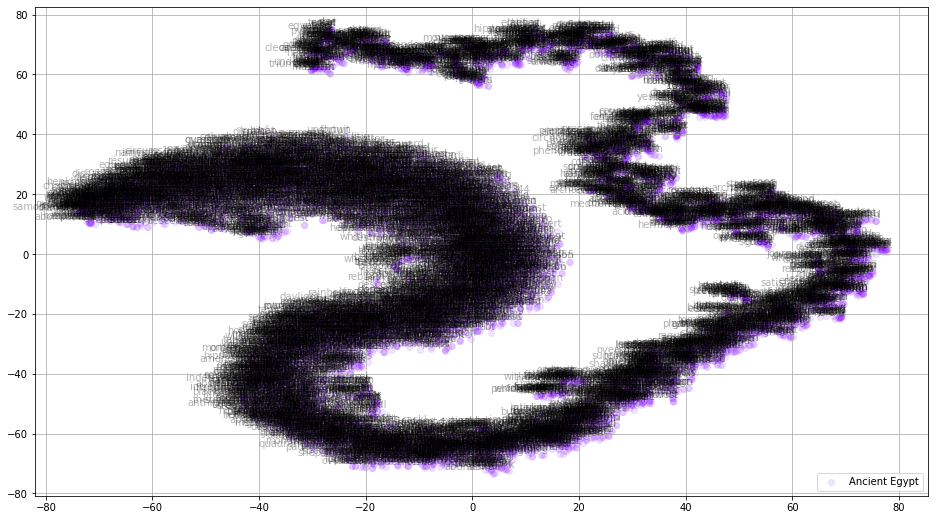

In [258]:
tsne_plot_2d('Ancient Egypt', X_tsne,vocab, a=0.1)

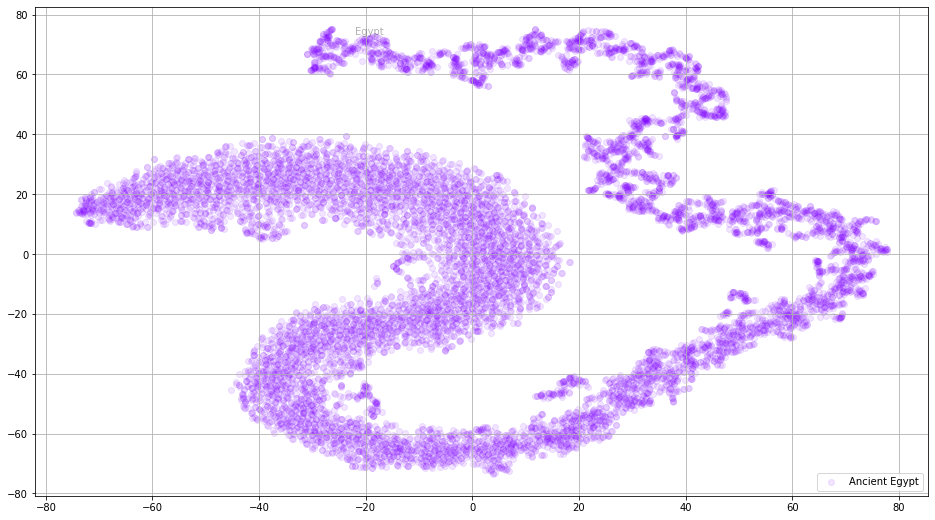

In [259]:
tsne_plot_2d('Ancient Egypt', X_tsne,['Egypt'], a=0.1)

### Doc2Vec

In [260]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


documents = [TaggedDocument(row['words'], [index]) for index, row in df.iterrows()]

# create model
#model = Doc2Vec().build_vocab(documents)

Doc2vec_model = Doc2Vec(documents, min_count=1)

In [261]:
Doc2vec_model.train(documents, total_examples=Doc2vec_model.corpus_count, epochs=10)

In [262]:
X_d2v = Doc2vec_model.docvecs.doctag_syn0

In [263]:
X_d2v.shape

(905, 100)

## TSNE

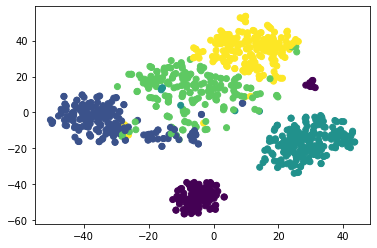

In [264]:
tsne = TSNE(n_components=2,random_state=100,n_jobs=-1)
data2D = tsne.fit_transform(X_tfidf)

plt.scatter(data2D[:,0], data2D[:,1], c=y)

# Evaluation


## Consistency

In [265]:
def get_consistency(X, labels_pred):
  ch_score = metrics.calinski_harabasz_score(X, labels_pred)
  print("Consistency = ", str(ch_score))

## Silhouette

In [266]:
from sklearn.metrics import silhouette_score

def get_silhouette(X, labels_pred):
  print("Silhouette Score = ", str(silhouette_score(X, labels_pred)))

## Kappa

In [267]:
from sklearn.metrics import cohen_kappa_score

def get_kappa(X, labels_true, model):
  d = {}
  for i in range(len(model.cluster_centers_)):
    d[i] = -1
  distance_df = pd.DataFrame(model.transform(X))
  for i in range(len(model.cluster_centers_)):
    m = distance_df.iloc[:,i].idxmin()
    from_ = model.labels_[m]
    to_ = labels_true[m]
    d[from_] = to_
  cleaned_predicted_labels = model.labels_.copy()
  for idx,i in enumerate(cleaned_predicted_labels):
    cleaned_predicted_labels[idx] = d[i]
  print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))

## Homogeneity, Completeness & V measure

In [268]:
#Extra
def get_hcv(labels_true, labels_pred):
  hcv = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
  print("Homogeneity = ", str(hcv[0]))
  print("Completeness = ", str(hcv[1]))
  print("V measure = ", str(hcv[2]))

## ?????

In [269]:
from sklearn.cluster import KMeans

#calculate distance between each data point of a cluster to their respective cluster centroids
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
        distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
        return distances
km = KMeans(n_clusters=5)        
clusters=km.fit_predict(data2D)
centroids = km.cluster_centers_

distances = []
for i, (cx, cy) in enumerate(centroids):
    mean_distance = k_mean_distance(data2D, cx, cy, i, clusters)
    distances.append(mean_distance)

print(distances)

[[5.867505829128974, 6.160043879125117, 12.083412518959904, 13.620214416228146, 10.070699759773238, 7.050678844190004, 9.310842572772891, 8.414031704527924, 12.324367317715268, 4.473013693051278, 8.357643176260003, 9.236964756353967, 14.862847663681347, 11.070149213412817, 4.4149504494793925, 7.542543083359052, 14.988267252342627, 9.677738426509205, 4.704792465511522, 13.31452498989041, 17.459115295939053, 10.848136543875933, 26.039410736328765, 8.666380730207305, 4.953079528748154, 5.994030973957214, 5.996292698132294, 9.83239942668369, 9.701793105448393, 8.261264042616794, 6.509297948230683, 23.821018541968094, 15.461174175467592, 9.120390307555901, 2.149196718092411, 8.27100737088952, 11.841648718012626, 5.644595681974828, 16.70829031799496, 4.959664731208156, 3.324722221418862, 6.638012206692276, 2.8432853181025233, 7.491423164073102, 10.304443475920221, 8.284869810450203, 20.044019326154483, 8.38821232451897, 20.142433600324356, 8.816128379095733, 10.093030370231626, 12.2420715274

## Error Analysis Functions

In [270]:
def print_tfidf(book_num,model,num):
  #Book1
  lst_tokens = df[df["label"]==book_num]["words"]
  test_list1 = []
  for i in lst_tokens :
    test_list1 = np.append(test_list1, i, axis=None)

  lst_tokens = test_list1

  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"]).sort_values(by="Freq")
  #print(dtf_uni.iloc[-10:])
  x_pre = Tfidf.transform(vectorizer.transform(dtf_uni['Word'].iloc[(-1*num):])).toarray()
  np.set_printoptions(threshold=np.inf)

  x = np.array(model.predict(x_pre))
  unique, counts = np.unique(x, return_counts=True)
  plt.bar(unique,counts, label= "Book"+str(book_num))
  plt.xticks(range(0,5))
  plt.title('Top '+str(num)+ ' Words in clusters for Book')
  plt.xlabel('Cluter')
  plt.ylabel('Number of words')
  plt.legend()
  #print (np.asarray((unique, counts)).T)

In [271]:
def print_lda(book_num,model,num):
  #Book1
  lst_tokens = df[df["label"]==book_num]["words"]
  test_list1 = []
  for i in lst_tokens :
    test_list1 = np.append(test_list1, i, axis=None)

  lst_tokens = test_list1

  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"]).sort_values(by="Freq")
  #print(dtf_uni.iloc[-10:])
  x_pre = LDA.transform(vectorizer.transform(dtf_uni['Word'].iloc[(-1*num):]))
  np.set_printoptions(threshold=np.inf)

  x = np.array(model.predict(x_pre))
  unique, counts = np.unique(x, return_counts=True)
  plt.bar(unique,counts, label= "Book"+str(book_num))
  plt.xticks(range(0,5))
  plt.title('Top '+str(num)+ ' Words in clusters for Book ')
  plt.xlabel('Cluter')
  plt.ylabel('Number of words')
  plt.legend()
  #print (np.asarray((unique, counts)).T)

In [272]:
def print_d2v(book_num,model,num):
  #Book1
  lst_tokens = df[df["label"]==book_num]["words"]
  test_list1 = []
  for i in lst_tokens :
    test_list1 = np.append(test_list1, i, axis=None)

  lst_tokens = test_list1

  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"]).sort_values(by="Freq")
  #print(dtf_uni.iloc[-10:])
  x_pre = Doc2vec_model[dtf_uni['Word'].iloc[(-1*num):]]
  np.set_printoptions(threshold=np.inf)

  x = np.array(model.predict(x_pre))
  unique, counts = np.unique(x, return_counts=True)
  plt.bar(unique,counts, label= "Book"+str(book_num))
  plt.xticks(range(0,5))
  plt.title('Top '+str(num)+ ' Words in clusters for Book ')
  plt.xlabel('Cluter')
  plt.ylabel('Number of words')
  plt.legend()
  #print (np.asarray((unique, counts)).T)

# Modeling

## Kmeans

### tfidf

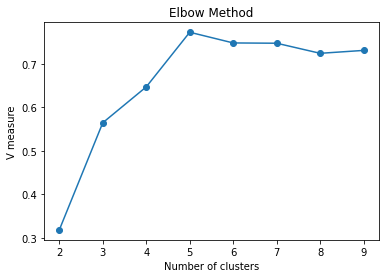

In [273]:
# Elbow method - kmeans - X from tfidf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import v_measure_score

score = []
for i in range(2,10):
  temp_model3 = KMeans(n_clusters=i, init='k-means++', random_state=0,n_jobs=-1)
  temp_model3.fit(X_tfidf)
  pred_l = temp_model3.labels_
  score.append(v_measure_score(y, pred_l))

plt.plot(range(2,10), score, marker = 'o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("V measure")

plt.show()

In [274]:

k_tfidf = KMeans(n_clusters=5, random_state=43)
k_tfidf = k_tfidf.fit(X_tfidf)
k_tfidf_labels = k_tfidf.predict(X_tfidf)

In [275]:
labels_true = y
labels_pred = k_tfidf_labels

get_consistency(X_tfidf.todense(), labels_pred)
get_silhouette(X_tfidf, labels_pred)
get_kappa(X_tfidf, labels_true.to_numpy(), k_tfidf)
get_hcv(labels_true, labels_pred)

Consistency =  15.49268564642377
Silhouette Score =  0.030945135788165445
Kappa =  0.850321892558215
Homogeneity =  0.7655586006924056
Completeness =  0.7841714990634288
V measure =  0.7747532755806299


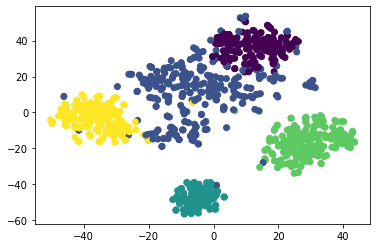

In [276]:
plt.scatter(data2D[:,0], data2D[:,1], c=k_tfidf_labels)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.01918033675465721
For n_clusters = 3 The average silhouette_score is : 0.022461968244427668
For n_clusters = 4 The average silhouette_score is : 0.027207423649985903
For n_clusters = 5 The average silhouette_score is : 0.030532109083933074
For n_clusters = 6 The average silhouette_score is : 0.028508353549546978


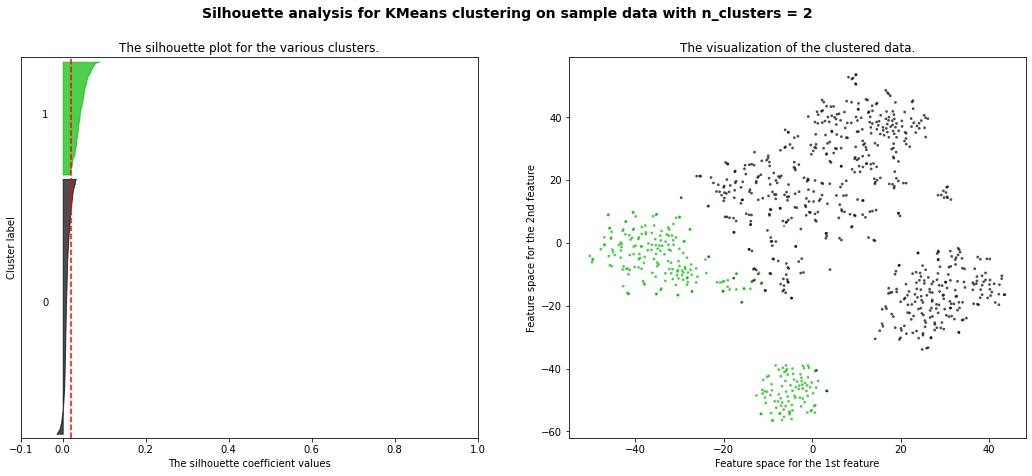

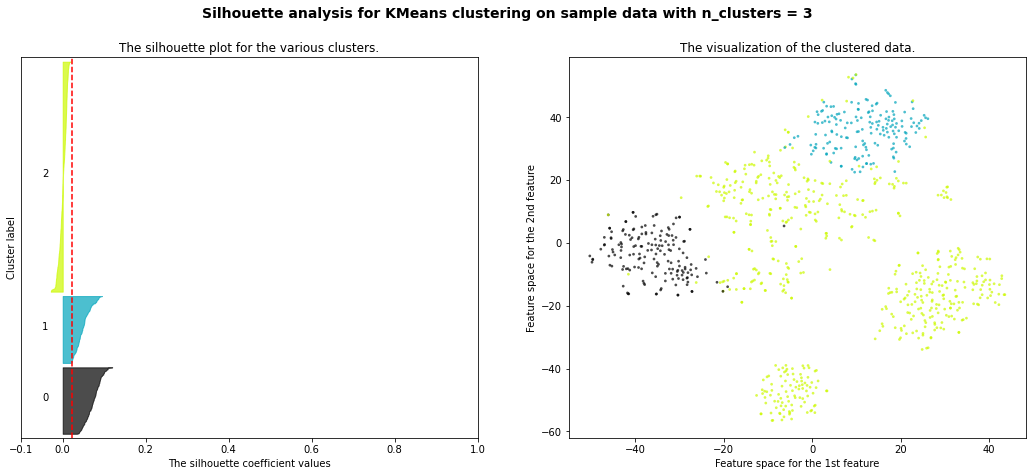

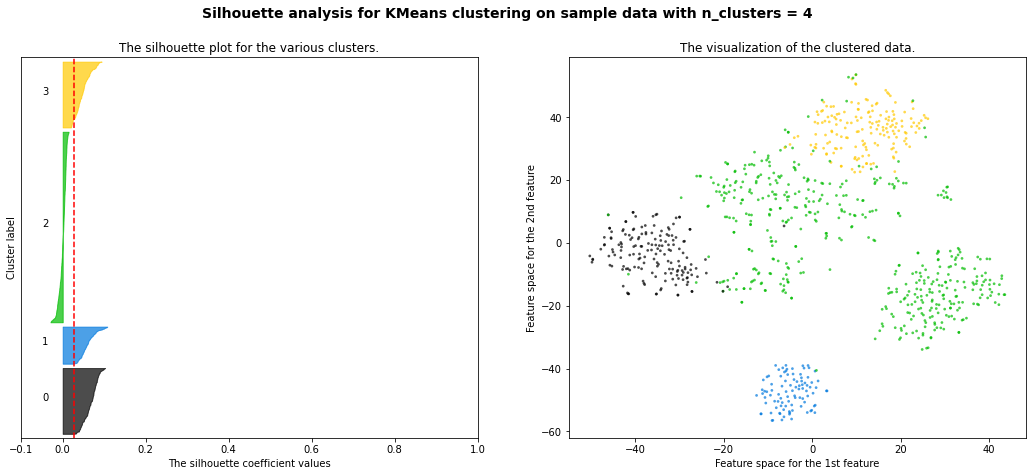

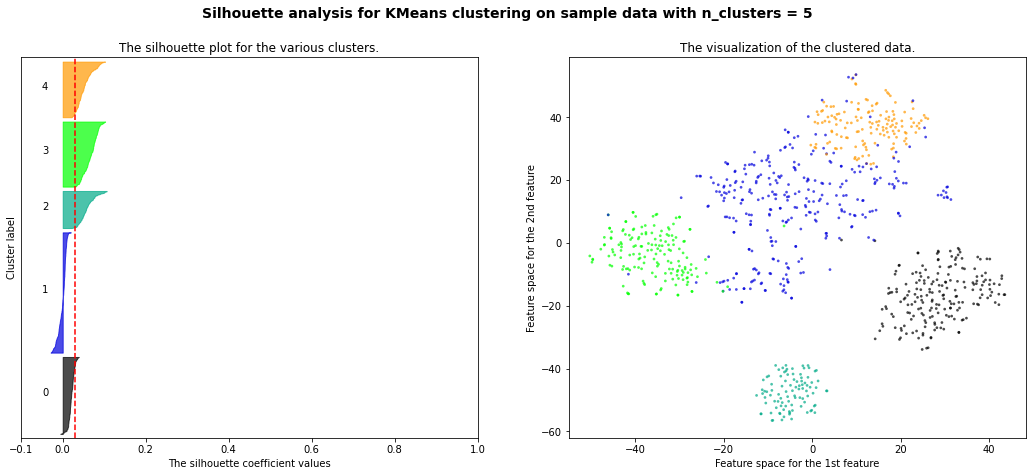

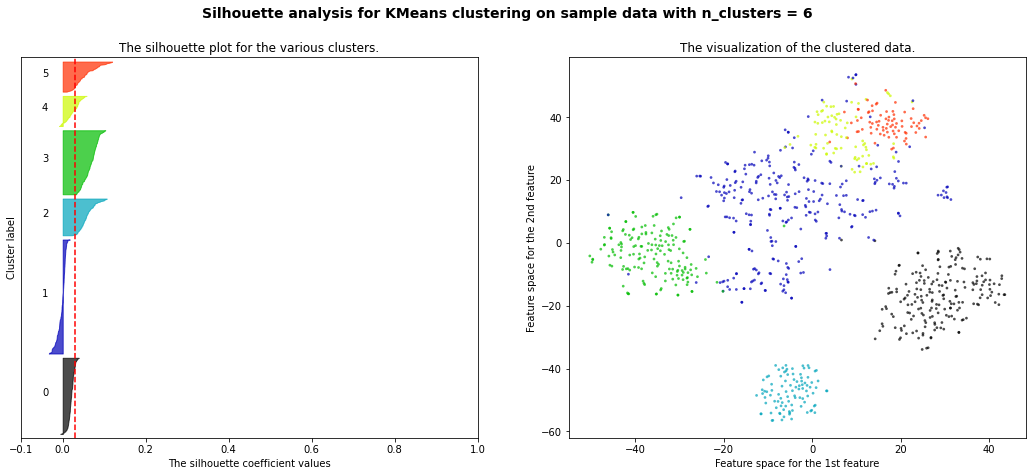

In [277]:
 #silhouette

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10 , n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X_tfidf)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_tfidf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tfidf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #centers = pca.transform(centers)
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                #c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    #s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Error

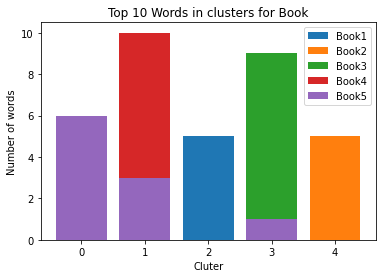

In [278]:
#book 1
print_tfidf(1,k_tfidf,10)

#book 2
print_tfidf(2,k_tfidf,10)

#book 3
print_tfidf(3,k_tfidf,10)

#book 4
print_tfidf(4,k_tfidf,10)

#book 5
print_tfidf(5,k_tfidf,10)

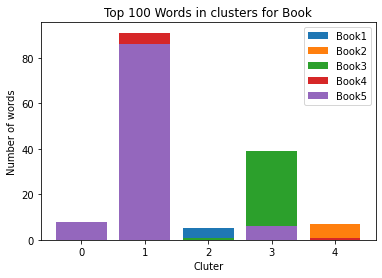

In [279]:
#book 1
print_tfidf(1,k_tfidf,100)

#book 2
print_tfidf(2,k_tfidf,100)

#book 3
print_tfidf(3,k_tfidf,100)

#book 4
print_tfidf(4,k_tfidf,100)

#book 5
print_tfidf(5,k_tfidf,100)

### LDA

In [280]:
k_lda = KMeans(n_clusters=5, random_state=43)
k_lda_labels = k_lda.fit_predict(X_lda)

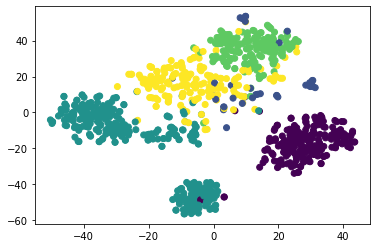

In [281]:
plt.scatter(data2D[:,0], data2D[:,1], c=k_lda_labels)

In [282]:
labels_true = y
labels_pred = k_lda_labels

get_consistency(X_lda, labels_pred)
get_silhouette(X_lda, labels_pred)
get_kappa(X_lda, labels_true, k_lda)
get_hcv(labels_true, labels_pred)

Consistency =  2057.931411023835
Silhouette Score =  0.7250447873729817
Kappa =  0.6132910497204667
Homogeneity =  0.6827346396622919
Completeness =  0.7358308787542964
V measure =  0.7082890756000593


#### Error

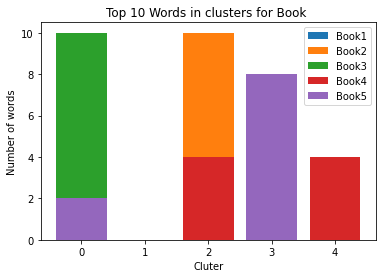

In [283]:
#book 1
print_lda(1,k_lda,10)

#book 2
print_lda(2,k_lda,10)

#book 3
print_lda(3,k_lda,10)

#book 4
print_lda(4,k_lda,10)

#book 5
print_lda(5,k_lda,10)

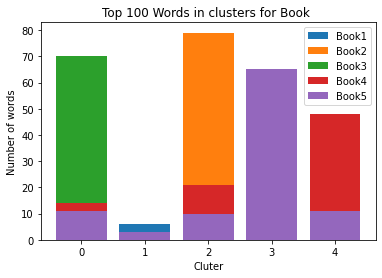

In [284]:
#book 1
print_lda(1,k_lda,100)

#book 2
print_lda(2,k_lda,100)

#book 3
print_lda(3,k_lda,100)

#book 4
print_lda(4,k_lda,100)

#book 5
print_lda(5,k_lda,100)

### Doc2Vec

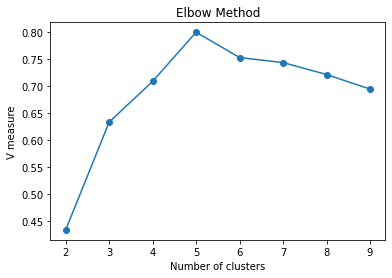

In [285]:
# Elbow method - kmeans - X from doc2vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import v_measure_score

score = []
for i in range(2,10):
  temp_model3 = KMeans(n_clusters=i, init='k-means++', random_state=0)
  temp_model3.fit(X_d2v)
  pred_l = temp_model3.labels_
  score.append(v_measure_score(y, pred_l))

plt.plot(range(2,10), score, marker = 'o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("V measure")

plt.show()

In [286]:
k_d2v = KMeans(n_clusters=5, random_state=43)
k_d2v_labels = k_d2v.fit_predict(X_d2v)

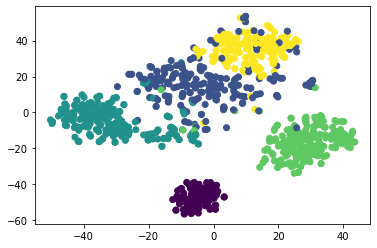

In [287]:
plt.scatter(data2D[:,0], data2D[:,1], c=k_d2v_labels)

In [288]:
labels_true = y
labels_pred = k_d2v_labels

get_consistency(X_d2v, labels_pred)
get_silhouette(X_d2v, labels_pred)
get_kappa(X_d2v, labels_true, k_d2v)
get_hcv(labels_true, labels_pred)

Consistency =  575.095210370085
Silhouette Score =  0.37804043
Kappa =  0.8755196661772661
Homogeneity =  0.7908250059446217
Completeness =  0.7983834040995197
V measure =  0.7945862308588625


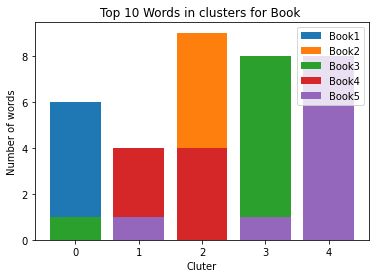

In [289]:
#book 1
print_d2v(1,k_d2v,10)

#book 2
print_d2v(2,k_d2v,10)

#book 3
print_d2v(3,k_d2v,10)

#book 4
print_d2v(4,k_d2v,10)

#book 5
print_d2v(5,k_d2v,10)

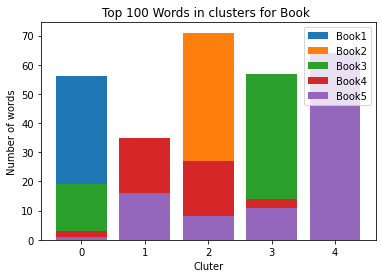

In [290]:
#book 1
print_d2v(1,k_d2v,100)

#book 2
print_d2v(2,k_d2v,100)

#book 3
print_d2v(3,k_d2v,100)

#book 4
print_d2v(4,k_d2v,100)

#book 5
print_d2v(5,k_d2v,100)

## EM

### tfidf

Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True


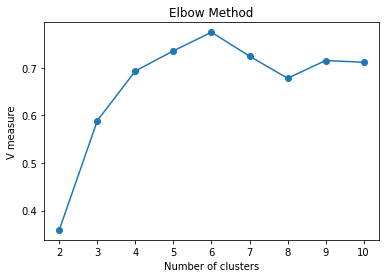

In [291]:
from sklearn.mixture import GaussianMixture

# Elbow method - EM - X from tfidf
wcss = []
for i in range(2, 11):
    gmm2 = GaussianMixture(n_components=i,verbose=1, random_state=42,covariance_type='diag')
    gmm2.fit(X_tfidf.toarray())
    labels2 = gmm2.predict(X_tfidf.toarray())
    wcss.append(v_measure_score(y, labels2))
plt.plot(range(2, 11), wcss, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('V measure')
plt.show()

In [292]:

gmm = GaussianMixture(n_components=5,verbose=1, random_state=42,covariance_type='diag')
gmm.fit(X_tfidf.toarray())

labels = gmm.predict(X_tfidf.toarray())
#plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis');

#gmm.predict_proba(X_tfidf.toarray())

Initialization 0
Initialization converged: True


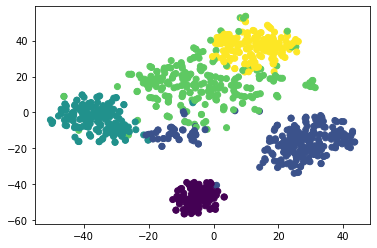

In [293]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

#### Error

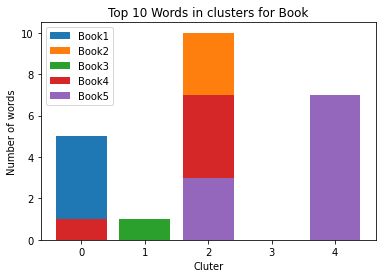

In [294]:
#book 1
print_tfidf(1,gmm,10)

#book 2
print_tfidf(2,gmm,10)

#book 3
print_tfidf(3,gmm,10)

#book 4
print_tfidf(4,gmm,10)

#book 5
print_tfidf(5,gmm,10)

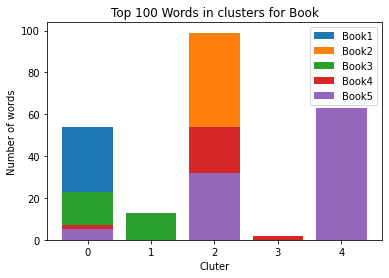

In [295]:
#book 1
print_tfidf(1,gmm,100)

#book 2
print_tfidf(2,gmm,100)

#book 3
print_tfidf(3,gmm,100)

#book 4
print_tfidf(4,gmm,100)

#book 5
print_tfidf(5,gmm,100)

In [296]:
# Preparing for Kappa calculation
print(labels[:25])
print(labels_true.to_list()[:25])

d = {}
for i in range(5):
  d[i] = -1

d[0]=1
d[1]=3
d[2]=2
d[3]=4
d[4]=5

cleaned_predicted_labels = labels.copy()
for idx,i in enumerate(cleaned_predicted_labels):
  cleaned_predicted_labels[idx] = d[i]

print(cleaned_predicted_labels[:25])

[4 2 3 1 3 4 3 4 3 4 1 4 1 4 1 1 1 0 4 1 1 1 3 4 4]
[5, 2, 4, 3, 4, 5, 4, 5, 4, 5, 3, 5, 3, 5, 3, 3, 4, 1, 5, 2, 3, 3, 4, 5, 5]
[5 2 4 3 4 5 4 5 4 5 3 5 3 5 3 3 3 1 5 3 3 3 4 5 5]


In [297]:
labels_true = y
labels_pred = labels

get_consistency(X_tfidf.todense(), labels_pred)
get_silhouette(X_tfidf, labels_pred)
print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))
get_hcv(labels_true, labels_pred)

Consistency =  15.400750527352752
Silhouette Score =  0.030596604204247417
Kappa =  0.8363332843860856
Homogeneity =  0.7294195685486753
Completeness =  0.7417962341863453
V measure =  0.7355558417539505


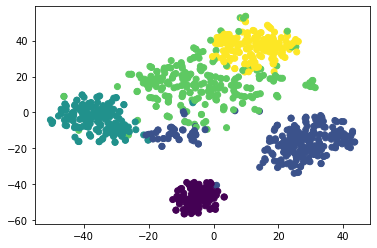

In [298]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

In [299]:
 from sklearn.metrics import silhouette_samples, silhouette_score

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(data2D, labels)
print("For n_clusters =", 5,
          "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data2D, labels)

For n_clusters = 5 The average silhouette_score is : 0.46056563


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.014074178568618458
For n_clusters = 3 The average silhouette_score is : 0.023781815721459317
For n_clusters = 4 The average silhouette_score is : 0.02629162084613361
For n_clusters = 5 The average silhouette_score is : 0.030596604204247417
For n_clusters = 6 The average silhouette_score is : 0.025410362798089135


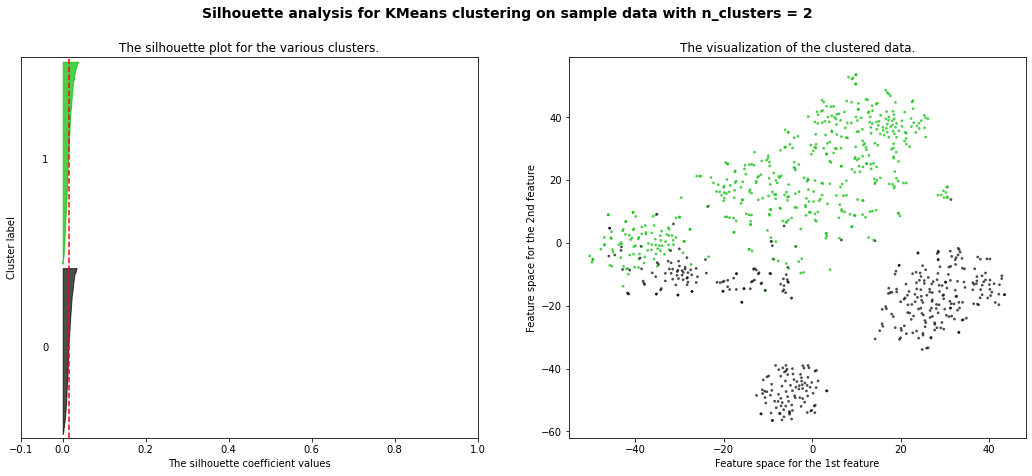

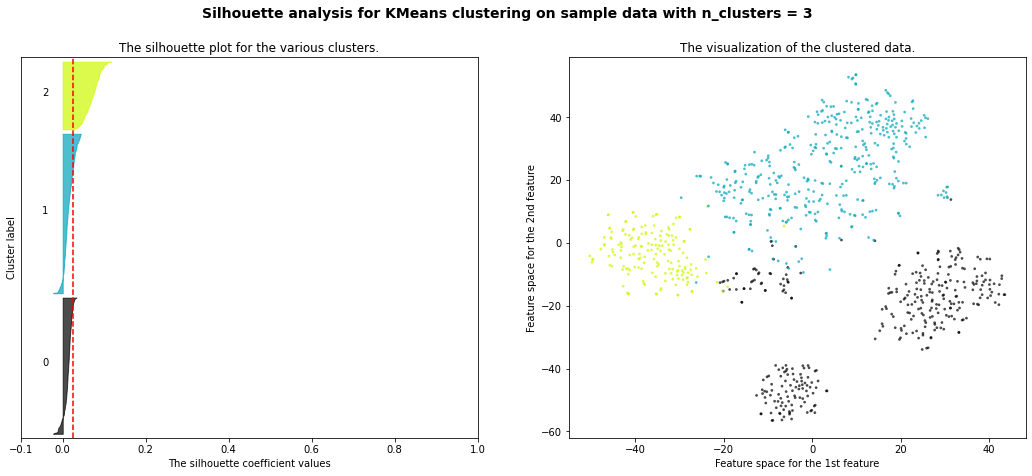

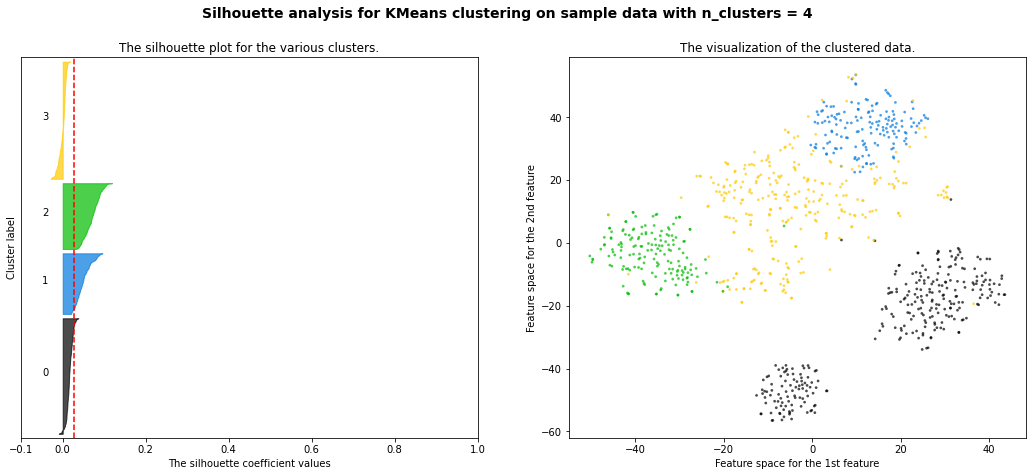

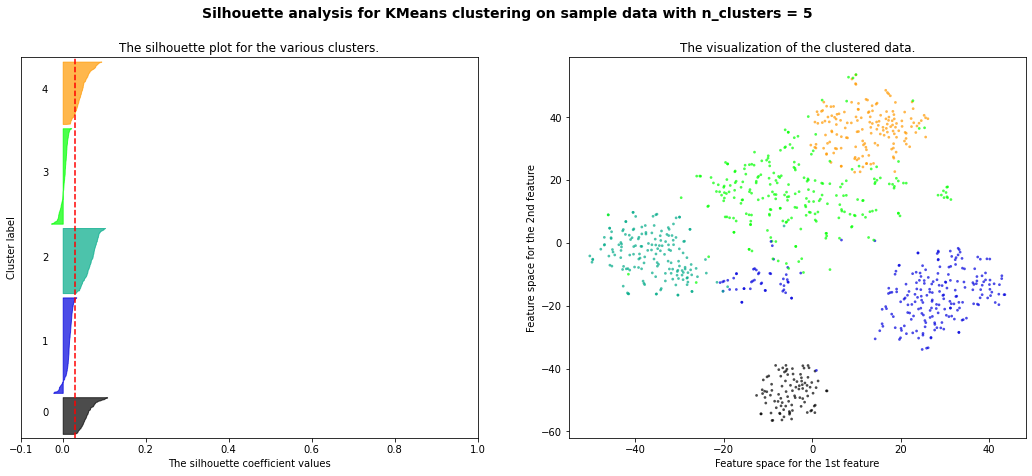

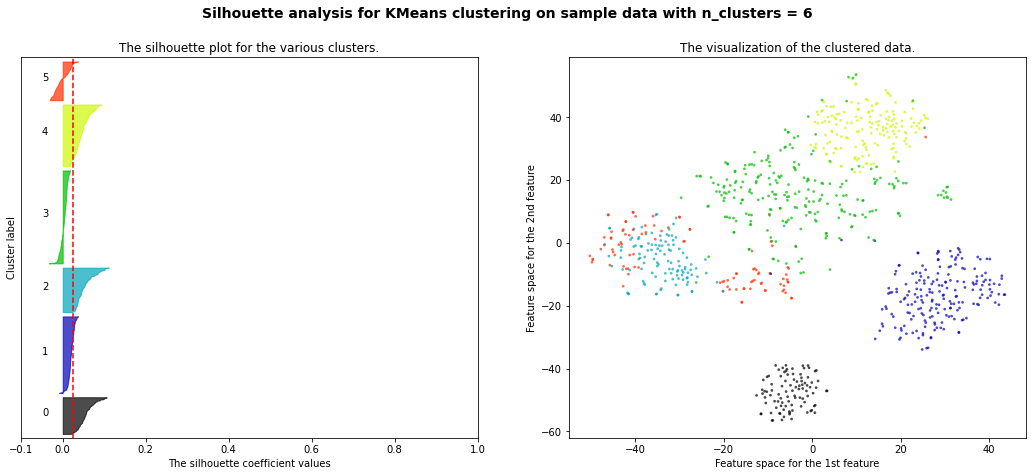

In [300]:
 #silhouette
print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=42,covariance_type='diag')
    cluster_labels=clusterer.fit_predict(X_tfidf.toarray())

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_tfidf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tfidf.toarray(), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #x2.scatter(centers[:, 0], centers[:, 1], marker='o',
                #c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    #s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### LDA

In [301]:
gmm_lda = GaussianMixture(n_components=5,verbose=1, random_state=42,covariance_type='diag')
gmm_lda.fit(X_lda)

labels = gmm_lda.predict(X_lda)

Initialization 0
  Iteration 10
Initialization converged: True


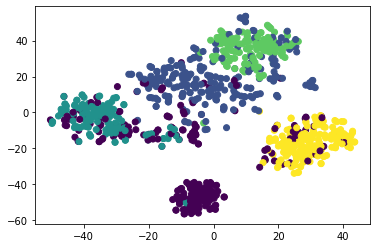

In [302]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

In [303]:
# Preparing for Kappa calculation
print(labels[:30])
print(labels_true.to_list()[:30])

d = {}
for i in range(5):
  d[i] = -1

d[0]=1
d[1]=3
d[2]=5
d[3]=2
d[4]=4

cleaned_predicted_labels = labels.copy()
for idx,i in enumerate(cleaned_predicted_labels):
  cleaned_predicted_labels[idx] = d[i]

print(cleaned_predicted_labels[:30])

[3 0 0 0 0 1 1 1 1 3 4 3 4 3 0 4 0 0 3 0 4 4 1 3 3 2 0 0 0 3]
[5, 2, 4, 3, 4, 5, 4, 5, 4, 5, 3, 5, 3, 5, 3, 3, 4, 1, 5, 2, 3, 3, 4, 5, 5, 2, 1, 4, 1, 5]
[2 1 1 1 1 3 3 3 3 2 4 2 4 2 1 4 1 1 2 1 4 4 3 2 2 5 1 1 1 2]


In [304]:
labels_true = y
labels_pred = labels

get_consistency(X_lda, labels_pred)
get_silhouette(X_lda, labels_pred)
print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))
get_hcv(labels_true, labels_pred)

Consistency =  743.8038128455235
Silhouette Score =  0.4492894548037513
Kappa =  -0.11137221607362169
Homogeneity =  0.6461112225508402
Completeness =  0.6470798638100578
V measure =  0.6465951804088915


#### Error 

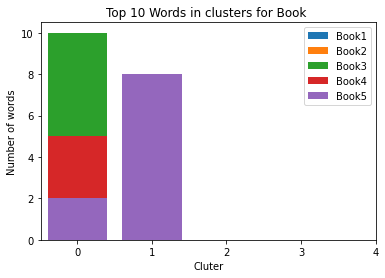

In [305]:
#book 1
print_lda(1,gmm_lda,10)

#book 2
print_lda(2,gmm_lda,10)

#book 3
print_lda(3,gmm_lda,10)

#book 4
print_lda(4,gmm_lda,10)

#book 5
print_lda(5,gmm_lda,10)

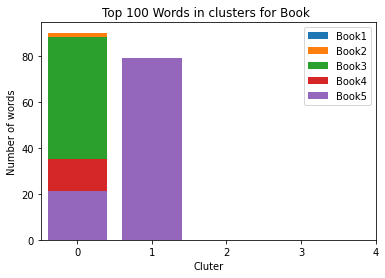

In [306]:
#book 1
print_lda(1,gmm_lda,100)

#book 2
print_lda(2,gmm_lda,100)

#book 3
print_lda(3,gmm_lda,100)

#book 4
print_lda(4,gmm_lda,100)

#book 5
print_lda(5,gmm_lda,100)

### Doc2Vec

Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
Initialization converged: True


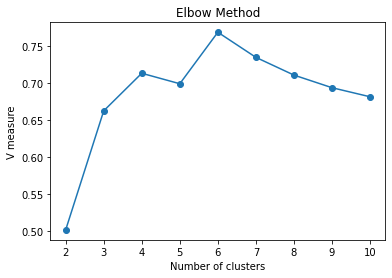

In [307]:
# Elbow method - EM - X from doc2vec
wcss = []
for i in range(2, 11):
    gmm2 = GaussianMixture(n_components=i,verbose=1, random_state=42,covariance_type='diag')
    gmm2.fit(X_d2v)
    labels2 = gmm2.predict(X_d2v)
    wcss.append(v_measure_score(y, labels2))
plt.plot(range(2, 11), wcss, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('V measure')
plt.show()

In [308]:
gmm_d2v = GaussianMixture(n_components=5, random_state=42,covariance_type='diag').fit(X_d2v)

labels = gmm_d2v.predict(X_d2v)

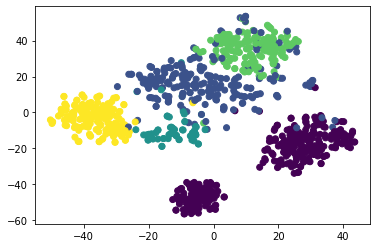

In [309]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

In [310]:
# Preparing for Kappa calculation
print(labels[:30])
print(labels_true.to_list()[:30])

d = {}
for i in range(5):
  d[i] = -1

d[0]=1
d[1]=4
d[2]=2
d[3]=5
d[4]=3 

cleaned_predicted_labels = labels.copy()
for idx,i in enumerate(cleaned_predicted_labels):
  cleaned_predicted_labels[idx] = d[i]

print(cleaned_predicted_labels[:30])

[3 4 1 0 1 3 1 3 1 3 0 3 0 3 0 0 2 0 3 2 0 0 1 3 3 4 0 2 0 3]
[5, 2, 4, 3, 4, 5, 4, 5, 4, 5, 3, 5, 3, 5, 3, 3, 4, 1, 5, 2, 3, 3, 4, 5, 5, 2, 1, 4, 1, 5]
[5 3 4 1 4 5 4 5 4 5 1 5 1 5 1 1 2 1 5 2 1 1 4 5 5 3 1 2 1 5]


In [311]:
labels_true = y
labels_pred = labels

get_consistency(X_d2v, labels_pred)
get_silhouette(X_d2v, labels_pred)
print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))
get_hcv(labels_true, labels_pred)

Consistency =  475.212607986439
Silhouette Score =  0.31472448
Kappa =  0.4029095936938766
Homogeneity =  0.6825270373668765
Completeness =  0.7158790503026036
V measure =  0.6988053207496243


#### Error

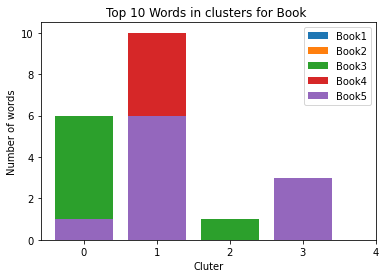

In [312]:
#book 1
print_d2v(1,gmm_d2v,10)

#book 2
print_d2v(2,gmm_d2v,10)

#book 3
print_d2v(3,gmm_d2v,10)

#book 4
print_d2v(4,gmm_d2v,10)

#book 5
print_d2v(5,gmm_d2v,10)

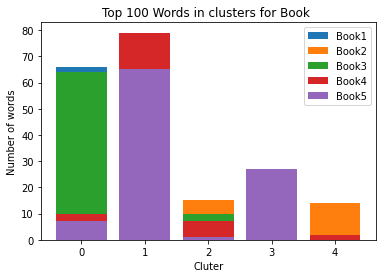

In [313]:
#book 1
print_d2v(1,gmm_d2v,100)

#book 2
print_d2v(2,gmm_d2v,100)

#book 3
print_d2v(3,gmm_d2v,100)

#book 4
print_d2v(4,gmm_d2v,100)

#book 5
print_d2v(5,gmm_d2v,100)

## hierarchical clustering (AgglomerativeClustering)

### tfidf

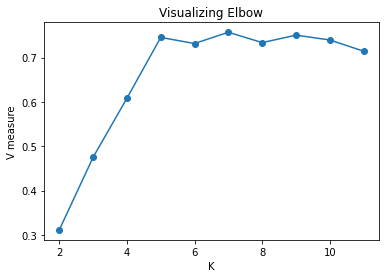

In [314]:
from sklearn.cluster import AgglomerativeClustering

# Elbow method - Hierarchical - X from tfidf
score = []
for i in range(2,12):
  temp_model3 = AgglomerativeClustering(n_clusters=i).fit(X_tfidf.toarray())
  pred_l = temp_model3.labels_
  score.append(v_measure_score(y, pred_l))

plt.plot(range(2,12), score, marker = 'o')
plt.title("Visualizing Elbow")
plt.xlabel("K")
plt.ylabel("V measure")

plt.show()

In [315]:
H_clustering = AgglomerativeClustering(n_clusters=5)
labels = H_clustering.fit_predict(X_tfidf.toarray())
#H_clustering.labels_

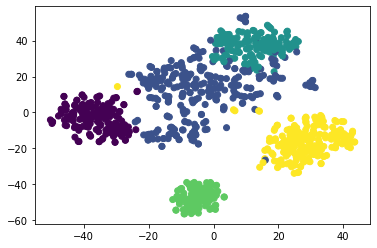

In [316]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

In [317]:
# Preparing for Kappa calculation
print(labels[:30])
print(labels_true.to_list()[:30])

d = {}
for i in range(5):
  d[i] = -1

d[0]=2
d[1]=4
d[2]=5
d[3]=1
d[4]=3

cleaned_predicted_labels = labels.copy()
for idx,i in enumerate(cleaned_predicted_labels):
  cleaned_predicted_labels[idx] = d[i]

print(cleaned_predicted_labels[:30])

[2 0 1 4 1 2 1 2 1 2 4 2 4 2 4 4 1 3 2 1 4 4 1 1 2 0 3 1 3 2]
[5, 2, 4, 3, 4, 5, 4, 5, 4, 5, 3, 5, 3, 5, 3, 3, 4, 1, 5, 2, 3, 3, 4, 5, 5, 2, 1, 4, 1, 5]
[5 2 4 3 4 5 4 5 4 5 3 5 3 5 3 3 4 1 5 4 3 3 4 4 5 2 1 4 1 5]


In [318]:
labels_true = y
labels_pred = labels

get_consistency(X_tfidf.toarray(), labels_pred)
get_silhouette(X_tfidf, labels_pred)
print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))
get_hcv(labels_true, labels_pred)

Consistency =  15.173365215781358
Silhouette Score =  0.02983178035356544
Kappa =  0.8265667259098988
Homogeneity =  0.7352180341930807
Completeness =  0.7561576787149267
V measure =  0.7455408550281033


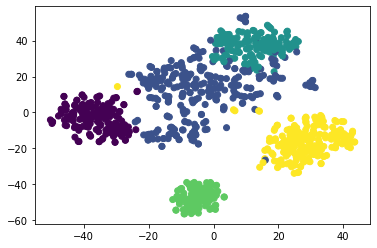

In [319]:
plt.scatter(data2D[:,0], data2D[:,1], c=H_clustering.labels_)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.017118729117077784
For n_clusters = 3 The average silhouette_score is : 0.02124578773129362
For n_clusters = 4 The average silhouette_score is : 0.026092084606794984
For n_clusters = 5 The average silhouette_score is : 0.02983178035356544
For n_clusters = 6 The average silhouette_score is : 0.022341861066476745


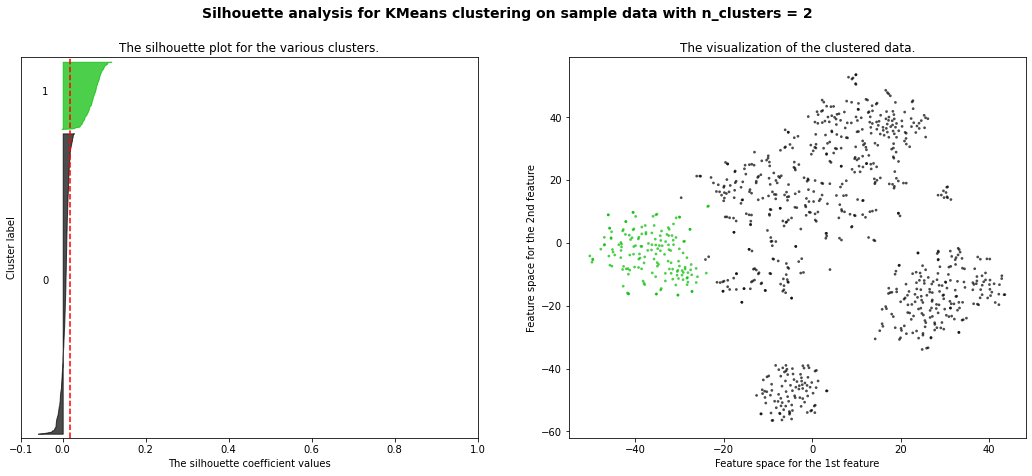

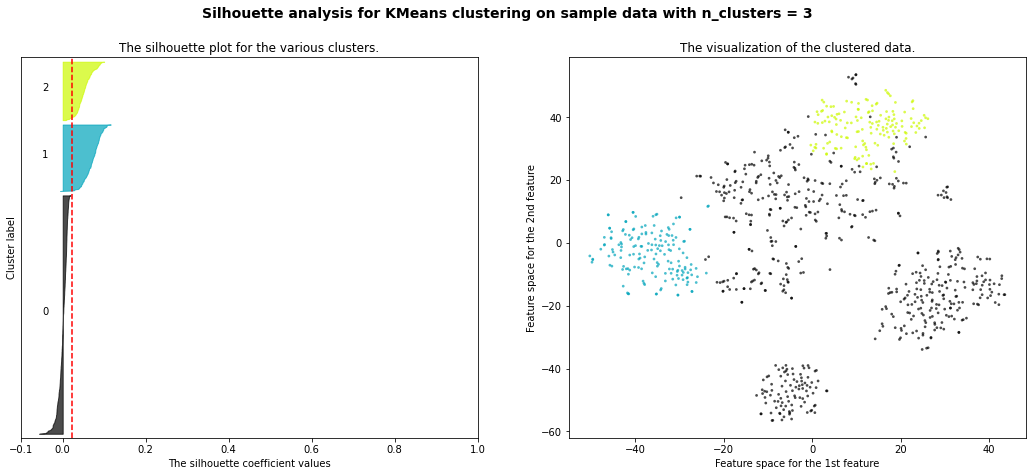

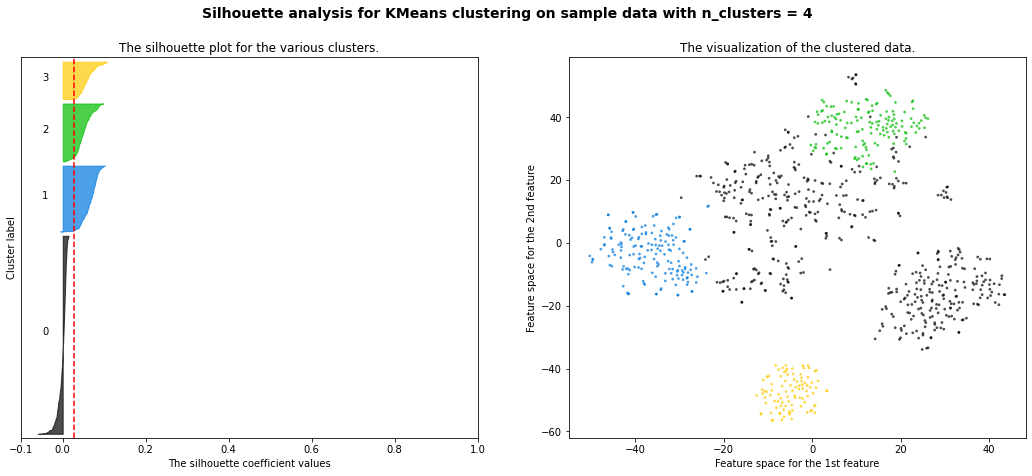

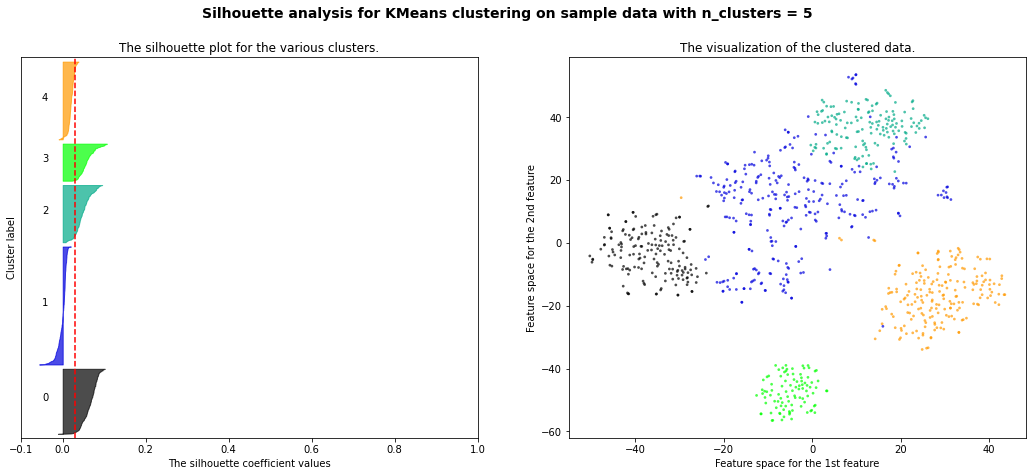

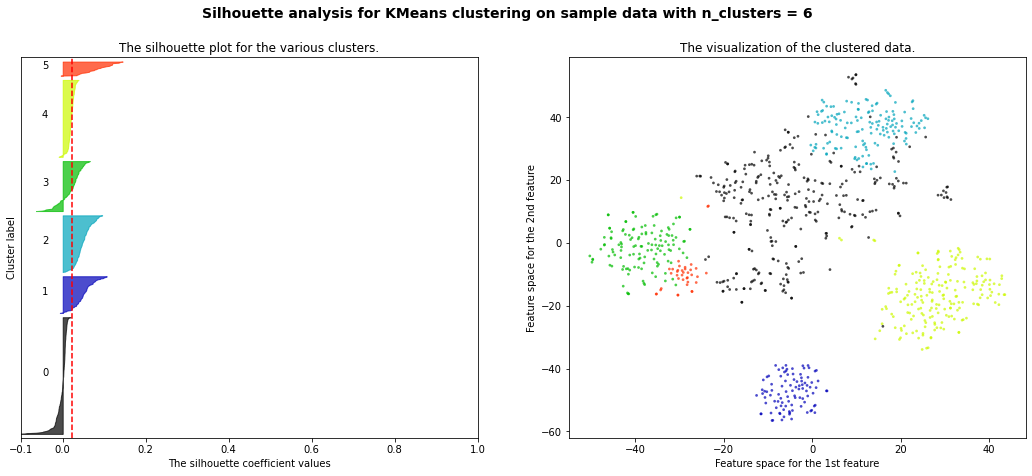

In [320]:
 #silhouette
print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels=clusterer.fit_predict(X_tfidf.toarray())

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_tfidf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_tfidf.toarray(), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data2D[:, 0], data2D[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #x2.scatter(centers[:, 0], centers[:, 1], marker='o',
                #c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    #s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Error 

### LDA

In [321]:
H_clustering = AgglomerativeClustering(n_clusters=5)
labels = H_clustering.fit_predict(X_lda)

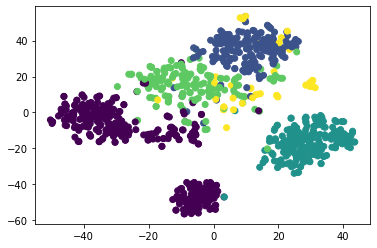

In [322]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

In [323]:
# Preparing for Kappa calculation
print(labels[:30])
print(labels_true.to_list()[:30])

d = {}
for i in range(5):
  d[i] = -1

d[0]=5
d[1]=4
d[2]=3
d[3]=2
d[4]=1

cleaned_predicted_labels = labels.copy()
for idx,i in enumerate(cleaned_predicted_labels):
  cleaned_predicted_labels[idx] = d[i]

print(cleaned_predicted_labels[:30])

[1 0 3 2 3 1 4 1 3 1 2 1 2 1 2 2 0 0 1 0 2 2 3 1 1 0 0 0 0 1]
[5, 2, 4, 3, 4, 5, 4, 5, 4, 5, 3, 5, 3, 5, 3, 3, 4, 1, 5, 2, 3, 3, 4, 5, 5, 2, 1, 4, 1, 5]
[4 5 2 3 2 4 1 4 2 4 3 4 3 4 3 3 5 5 4 5 3 3 2 4 4 5 5 5 5 4]


In [324]:
labels_true = y
labels_pred = labels

get_consistency(X_lda, labels_pred)
get_silhouette(X_lda, labels_pred)
print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))
get_hcv(labels_true, labels_pred)

Consistency =  1714.187745395905
Silhouette Score =  0.6984640913262365
Kappa =  0.02623772782834155
Homogeneity =  0.6799422270501098
Completeness =  0.730245889302611
V measure =  0.7041968521913325


### Doc2Vec

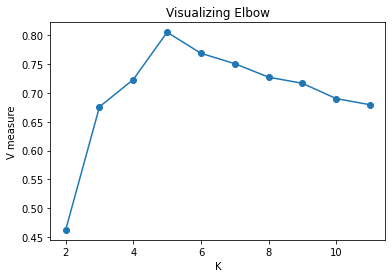

In [325]:
# Elbow method - Hierarchical - X from doc2vec
score = []
for i in range(2,12):
  temp_model3 = AgglomerativeClustering(n_clusters=i).fit(X_d2v)
  pred_l = temp_model3.labels_
  score.append(v_measure_score(y, pred_l))

plt.plot(range(2,12), score, marker = 'o')
plt.title("Visualizing Elbow")
plt.xlabel("K")
plt.ylabel("V measure")

plt.show()

In [326]:
H_clustering = AgglomerativeClustering(n_clusters=5)
labels = H_clustering.fit_predict(X_d2v)

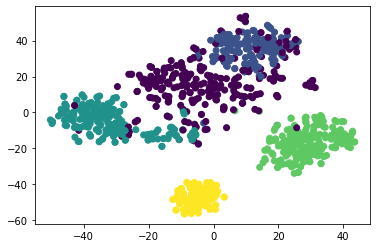

In [327]:
plt.scatter(data2D[:,0], data2D[:,1], c=labels)

In [328]:
# Preparing for Kappa calculation
print(labels[:30])
print(labels_true.to_list()[:30])

d = {}
for i in range(5):
  d[i] = -1

d[0]=4
d[1]=3
d[2]=2
d[3]=5
d[4]=1

cleaned_predicted_labels = labels.copy()
for idx,i in enumerate(cleaned_predicted_labels):
  cleaned_predicted_labels[idx] = d[i]

print(cleaned_predicted_labels[:30])

[1 2 0 3 0 1 0 1 0 1 3 1 3 0 3 3 0 4 1 2 3 3 0 1 1 2 4 0 4 1]
[5, 2, 4, 3, 4, 5, 4, 5, 4, 5, 3, 5, 3, 5, 3, 3, 4, 1, 5, 2, 3, 3, 4, 5, 5, 2, 1, 4, 1, 5]
[3 2 4 5 4 3 4 3 4 3 5 3 5 4 5 5 4 1 3 2 5 5 4 3 3 2 1 4 1 3]


In [329]:
labels_true = y
labels_pred = labels

get_consistency(X_d2v, labels_pred)
get_silhouette(X_d2v, labels_pred)
print("Kappa = ", cohen_kappa_score(labels_true, cleaned_predicted_labels))
get_hcv(labels_true, labels_pred)

Consistency =  528.4923374416389
Silhouette Score =  0.35852286
Kappa =  0.3985781624294876
Homogeneity =  0.7989516582431259
Completeness =  0.8124078468301299
V measure =  0.8056235673679182


#visualization

In [216]:
#pip install scattertext

In [217]:
import plotly.express as px
fig = px.bar(df[:20], x='words', title='Counts of top bigrams', template='plotly_white', labels={'ngram': 'Bigram', 'count': 'Count'})
fig.show()

In [218]:
import spacy
nlp = spacy.load('en_core_web_sm')  
df["words"]

0      [orient, therefor, give, us, inform, toward, d...
1      [hermopoli, magna, feet, statu, god, inscrib, ...
2      [fought, thalû, zaru, shaï, nubia, thalû, horu...
3      [along, base, vast, monument, king, cheop, vai...
4      [suprem, jackal, hand, realist, accord, might,...
                             ...                        
900    [listen, thu, spake, behold, thi, mother, thi,...
901    [typhon, wife, call, taurt, thoueri, repres, g...
902    [god, cometh, forth, hidden, habit, food, fall...
903    [gold, far, away, across, gleam, floor, blosso...
904    [see, earli, observ, made, horizon, obviou, li...
Name: words, Length: 905, dtype: object

In [219]:
flat_words = [item for sublist in df["words"] for item in sublist]
doc = spacy.tokens.Doc(nlp.vocab, words=flat_words)


In [220]:
doc

orient therefor give us inform toward determin quarter heaven particular star might 4 case date foundat templ dedic particular divin thoroughli known difficulti find star declin time would give amplitud case seri templ dedic divin addit check afford chang amplitud latest newest templ agre chang declin star 5 declin star thu determin certain epoch next plot curv show amplitud year 5000 thebe true horizon horizon rais hill mist final tabl prepar show declin proper amplitud chief templ need inform avail although howev matter discuss way indic inquiri rais wish one moment speak settl observ made alreadi egypt regard orient templ made special point view consider alter amplitud would made presenc even low rang hill mile away case star rise set mani degre north south one would care make assert absolut definit known whether horizon case interf hill interven object one fact might regard sea horizon point observ impedi angular height hermopoli magna feet statu god inscrib upon slab iron south wr

In [221]:
doc=nlp(str(doc))

In [222]:
from spacy import displacy
displacy.render(doc, style="dep" ,jupyter=True)

In [ ]:
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.dep_)

In [ ]:
for token in doc:
    # Print the token and its part-of-speech tag
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))

In [ ]:
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.lemma_)

In [ ]:
sentences = list(doc.sents)
len(sentences)
for sentence in sentences:
     print (sentence)

In [ ]:
#ner
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
# NED Name Entity Detection:
entities=[(i, i.label_, i.label) for i in doc.ents]
entities

In [ ]:
# use displayC:

displacy.render(doc, style = "ent",jupyter = True)

In [ ]:
 # Similarity measures
for token in doc:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
# بسم الله
X = np.array(df['text'])
y = np.array(df['label'])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Tfidf & BOW
cv = CountVectorizer()
tfidf = TfidfVectorizer()
X_Bow = cv.fit_transform(X)
X_Tfidf = tfidf.fit_transform(X)
test_size = 0.3

# Using BOW
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_Bow, y, test_size=test_size, random_state=69);
# Using Tfidf
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_Tfidf, y, test_size=test_size, random_state=69);


In [ ]:
# get the best K
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=69)
    kmeans.fit(X_train_tfidf)
    wcss.append(kmeans.inertia_)
# End of for

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
# get the best K
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1, random_state=69)
    kmeans.fit(X_train_bow)
    wcss.append(kmeans.inertia_)
# End of for

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
number_of_clusters = 10
# K-Means using BOW
model_bow = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1)
label = model_bow.fit_predict(X_train_bow)
print("Top terms per cluster:")
order_centroids = model_bow.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [ ]:
# K-Means using TFIDF
number_of_clusters = 5
# K-Means using TFIDF
model_tfidf = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1)
label = model_tfidf.fit_predict(X_train_tfidf)
print("Top terms per cluster:")
order_centroids = model_tfidf.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [ ]:
# Word2Vec using PCA
import smart_open
smart_open.open = smart_open.smart_open
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.models import Word2Vec

# define training data
sentences = [nltk.word_tokenize(s) for s in X]
# train model
model = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
#!pip install pyLDAvis
# LDA
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dictionary = corpora.Dictionary(sentences)
doc_term_matrix = [dictionary.doc2bow(s) for s in sentences]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100, chunksize=1000, passes=50,iterations=100)
lda_model.print_topics()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis